In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.5.1-bin-hadoop3"

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# Crear la sesión de Spark con configuraciones para evitar que se apague
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Regresion") \
    .config("spark.driver.idleTimeout", "3600s") \
    .config("spark.network.timeout", "3600s") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

# Configuración adicional para mejorar la salida de las tablas
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

# Verificar la sesión de Spark
spark

25/02/17 22:45:04 WARN Utils: Your hostname, codespaces-8b4e98 resolves to a loopback address: 127.0.0.1; using 10.0.3.178 instead (on interface eth0)
25/02/17 22:45:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/17 22:45:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
rdd = spark.sparkContext.textFile("CHAT1.txt")

In [4]:

from pyspark.sql.types import *
import re
from datetime import datetime

def process_chat(rdd):
    messages = []
    current_message = None
    current_text = []
    
    for line in rdd.collect():
        # Patrón para detectar nuevo mensaje
        pattern = r'(\d{1,2})/(\d{1,2})/(\d{2})\s(\d{1,2}:\d{1,2}\s[ap]\.\sm\.)\s-\s([^:]+):\s(.+)'
        match = re.match(pattern, line)
        
        if match:
            # Si hay un mensaje anterior, guardarlo
            if current_message:
                dia, mes, año, hora, miembro, _ = current_message
                mensaje_completo = ' '.join(current_text)
                messages.append((int(f"20{año}"), int(mes), int(dia), hora.strip(), miembro.strip(), mensaje_completo.strip()))
            
            # Iniciar nuevo mensaje
            current_message = match.groups()
            current_text = [match.group(6)]
        else:
            # Agregar línea al mensaje actual
            if current_message:
                current_text.append(line.strip())
    
    # Procesar el último mensaje
    if current_message:
        dia, mes, año, hora, miembro, _ = current_message
        mensaje_completo = '\n'.join(current_text)
        messages.append((int(f"20{año}"), int(mes), int(dia), hora.strip(), miembro.strip(), mensaje_completo.strip()))
    
    return messages

# Leer archivo de chat
messages = process_chat(rdd)

# Esquema con las nuevas columnas
schema = StructType([
    StructField("Año", IntegerType(), True),
    StructField("Mes", IntegerType(), True),
    StructField("Día", IntegerType(), True),
    StructField("Hora", StringType(), True),
    StructField("Miembro", StringType(), True),
    StructField("Mensaje", StringType(), True)
])

# Crear DataFrame con los datos procesados
df = spark.createDataFrame(messages, schema)

# Mostrar resultado
df.show(10)


+----+---+---+----------+---------+--------------------+
| Año|Mes|Día|      Hora|  Miembro|             Mensaje|
+----+---+---+----------+---------+--------------------+
|2024|  8| 31|1:17 a. m.|  Maryori|Kevin me contó qu...|
|2024|  8| 31|1:17 a. m.|Maricielo|            Ay amiga|
|2024|  8| 31|1:18 a. m.|  Maryori|Que cólera amiga ...|
|2024|  8| 31|1:18 a. m.|Maricielo|A estrella le eje...|
|2024|  8| 31|1:18 a. m.|Maricielo|               Bueno|
|2024|  8| 31|1:18 a. m.|Maricielo|       Ni modo amiga|
|2024|  8| 31|1:19 a. m.|Maricielo|Nose si llorar o ...|
|2024|  8| 31|1:19 a. m.|Maricielo|Pero bueno a segu...|
|2024|  8| 31|1:21 a. m.|  Maryori|Imagínate amiga e...|
|2024|  8| 31|1:22 a. m.|Maricielo|Y sabes amiga a l...|
+----+---+---+----------+---------+--------------------+
only showing top 10 rows



In [5]:

# Agregar columnas de análisis de mensajes para los indicadores
from pyspark.sql.functions import size, split, when, length
df = df.withColumn(
    "Cantidad_Palabras", 
    size(split("Mensaje", " "))
).withColumn(
    "Respuesta_Corta",
    when(
        (length("Mensaje") <= 20) & 
        (size(split("Mensaje", " ")) <= 3), 
        1
    ).otherwise(0)
)
df.show(10)

+----+---+---+----------+---------+--------------------+-----------------+---------------+
| Año|Mes|Día|      Hora|  Miembro|             Mensaje|Cantidad_Palabras|Respuesta_Corta|
+----+---+---+----------+---------+--------------------+-----------------+---------------+
|2024|  8| 31|1:17 a. m.|  Maryori|Kevin me contó qu...|               13|              0|
|2024|  8| 31|1:17 a. m.|Maricielo|            Ay amiga|                2|              1|
|2024|  8| 31|1:18 a. m.|  Maryori|Que cólera amiga ...|               10|              0|
|2024|  8| 31|1:18 a. m.|Maricielo|A estrella le eje...|               15|              0|
|2024|  8| 31|1:18 a. m.|Maricielo|               Bueno|                1|              1|
|2024|  8| 31|1:18 a. m.|Maricielo|       Ni modo amiga|                3|              1|
|2024|  8| 31|1:19 a. m.|Maricielo|Nose si llorar o ...|                9|              0|
|2024|  8| 31|1:19 a. m.|Maricielo|Pero bueno a segu...|                5|              0|

In [6]:

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# Listas de palabras clave
palabras_positivas = ["bueno", "excelente", "feliz", "genial", "alegría", "si", "claro", "bien", "gracias","aceptar","apoyo","tranquila","con fe", "facil","accesible", "si se puede", "bendiciones", "mejor"]
palabras_negativas = ["mal", "triste", "horrible", "estresado", "difícil", "no", "terrible", "peor", "nunca", "problema","cólera","injusticia","cansé","preocupa","perdida","molesto","problema"]

# Función UDF para clasificar correctamente los mensajes
def clasificar_mensaje(mensaje):
    if not mensaje:
        return "Neutral"
    
    mensaje = mensaje.lower()  # Convertir a minúsculas
    
    # Verificar si el mensaje contiene palabras negativas exactas
    if any(palabra in mensaje.split() for palabra in palabras_negativas):
        return "Negativo"
    
    # Verificar si el mensaje contiene palabras positivas exactas
    if any(palabra in mensaje.split() for palabra in palabras_positivas):
        return "Positivo"
    
    return "Neutral"

# Convertir la función en una UDF de Spark
clasificar_udf = udf(clasificar_mensaje, StringType())

# Aplicar la UDF al DataFrame
df = df.withColumn("Expresiones", clasificar_udf(col("Mensaje")))

df.show(10)


+----+---+---+----------+---------+--------------------+-----------------+---------------+-----------+
| Año|Mes|Día|      Hora|  Miembro|             Mensaje|Cantidad_Palabras|Respuesta_Corta|Expresiones|
+----+---+---+----------+---------+--------------------+-----------------+---------------+-----------+
|2024|  8| 31|1:17 a. m.|  Maryori|Kevin me contó qu...|               13|              0|    Neutral|
|2024|  8| 31|1:17 a. m.|Maricielo|            Ay amiga|                2|              1|    Neutral|
|2024|  8| 31|1:18 a. m.|  Maryori|Que cólera amiga ...|               10|              0|   Negativo|
|2024|  8| 31|1:18 a. m.|Maricielo|A estrella le eje...|               15|              0|    Neutral|
|2024|  8| 31|1:18 a. m.|Maricielo|               Bueno|                1|              1|   Positivo|
|2024|  8| 31|1:18 a. m.|Maricielo|       Ni modo amiga|                3|              1|    Neutral|
|2024|  8| 31|1:19 a. m.|Maricielo|Nose si llorar o ...|                9

In [ ]:

def detectar_tema_academico(texto):
    palabras_academicas = ['tarea', 'examen', 'clase', 'profesor', 'curso', 'estudiar', 
                          'práctica', 'parcial', 'final', 'investigación', 'informe','tesis',
                          'laboratorio','documento','teórico','sistemas',"información","mapa",
                          'procesos','organigrama','metodología','matricula','nivel','evaluación',
                          'resultados','documentación','normas','backend','frontend','programación']
    texto = texto.lower()
    return 1 if any(palabra in texto for palabra in palabras_academicas) else 0

temas_academicos_udf = udf(detectar_tema_academico, IntegerType())

# Crear DataFrame con temas académicos
df = df.withColumn("Temas_academicos", temas_academicos_udf("Mensaje"))
df.show(10)

NameError: name 'df_analizado' is not defined

In [8]:

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# Listas de palabras clave para cada registro lingüístico
palabras_formales = ["estimado", "por favor", "agradecería", "saludos", "cordialmente", "atentamente", "disculpe", "según", "indicar",
                     "presentar","ejecutar","revisar","verificar","comunicado","solicitar","información","dispuesto","disponible",
                     "estrategico","pertinencia","contribución","científica","novedad","temática","técnica"]
palabras_coloquiales = ["amiga", "bueno", "chevere", "bro", "pucha", "oye", 
                        "jaja", "chamba", "patas", "nada que ver",
                        "profe","lab","afuera","jeje","okis","di","ve","porfa","ps","porsiaca","tamos",
                        "avisa","chela","eliminaste","holis","aver","luego","diapos","chale","derrepente","nomás","pipipi"]
palabras_vulgares = ["tmre", "jato", "joder", "chingada","f","pucha"]

# Función UDF para clasificar el registro lingüístico
def clasificar_registro(mensaje):
    if not mensaje:
        return "Coloquial"  # Por defecto, si el mensaje está vacío

    mensaje = mensaje.lower()  # Convertir a minúsculas
    
    # Clasificación de registros
    if any(palabra in mensaje.split() for palabra in palabras_vulgares):
        return "Vulgar"
    elif any(palabra in mensaje.split() for palabra in palabras_formales):
        return "Formal"
    elif any(palabra in mensaje.split() for palabra in palabras_coloquiales):
        return "Coloquial"
    
    return "Coloquial"  # Si no encaja en otro, se considera coloquial

# Convertir la función en una UDF de Spark
registro_udf = udf(clasificar_registro, StringType())

# Aplicar la UDF al DataFrame
df = df.withColumn("Registro_Linguistico", registro_udf(col("Mensaje")))

df.show(10)


+----+---+---+----------+---------+--------------------+-----------------+---------------+-----------+----------------+--------------------+
| Año|Mes|Día|      Hora|  Miembro|             Mensaje|Cantidad_Palabras|Respuesta_Corta|Expresiones|Temas_academicos|Registro_Linguistico|
+----+---+---+----------+---------+--------------------+-----------------+---------------+-----------+----------------+--------------------+
|2024|  8| 31|1:17 a. m.|  Maryori|Kevin me contó qu...|               13|              0|    Neutral|               0|           Coloquial|
|2024|  8| 31|1:17 a. m.|Maricielo|            Ay amiga|                2|              1|    Neutral|               0|           Coloquial|
|2024|  8| 31|1:18 a. m.|  Maryori|Que cólera amiga ...|               10|              0|   Negativo|               0|           Coloquial|
|2024|  8| 31|1:18 a. m.|Maricielo|A estrella le eje...|               15|              0|    Neutral|               0|           Coloquial|
|2024|  8| 31

In [9]:

from pyspark.sql.functions import col, when, lower, size, split, expr
# Palabras clave para identificar la actividad
actividad_keywords = ["comida", "fiesta", "peloteo"]

# Crear la columna "Actividad" basada en la primera coincidencia
actividad_expr = when(lower(col("Mensaje")).contains(actividad_keywords[0]), actividad_keywords[0].capitalize())

for keyword in actividad_keywords[1:]:
    actividad_expr = actividad_expr.when(lower(col("Mensaje")).contains(keyword), keyword.capitalize())

df = df.withColumn("Actividad", actividad_expr.otherwise("Ninguna"))
# Contar la cantidad de veces que la palabra clave aparece en el mensaje
df = df.withColumn(
    "Cantidad_Actividad",
    when(
        col("Actividad") == "Ninguna",  # Si no hay actividad, cantidad debe ser 0
        0
    ).otherwise(
        expr("size(split(lower(Mensaje), lower(Actividad))) - 1")  # Contar ocurrencias correctamente
    )
)
df.show(10)

+----+---+---+----------+---------+--------------------+-----------------+---------------+-----------+----------------+--------------------+---------+------------------+
| Año|Mes|Día|      Hora|  Miembro|             Mensaje|Cantidad_Palabras|Respuesta_Corta|Expresiones|Temas_academicos|Registro_Linguistico|Actividad|Cantidad_Actividad|
+----+---+---+----------+---------+--------------------+-----------------+---------------+-----------+----------------+--------------------+---------+------------------+
|2024|  8| 31|1:17 a. m.|  Maryori|Kevin me contó qu...|               13|              0|    Neutral|               0|           Coloquial|  Ninguna|                 0|
|2024|  8| 31|1:17 a. m.|Maricielo|            Ay amiga|                2|              1|    Neutral|               0|           Coloquial|  Ninguna|                 0|
|2024|  8| 31|1:18 a. m.|  Maryori|Que cólera amiga ...|               10|              0|   Negativo|               0|           Coloquial|  Ninguna|

In [10]:

#DEPURACION
#1. VERIFICAR EL % DE FILAS CON VALORES NULOS O ESPACIOS VACIOS
from pyspark.sql import functions as F

# Calcular el porcentaje de datos faltantes (nulos o vacíos) para cada columna
porcentaje_faltantes = [(col, (df.filter((F.col(col).isNull()) | (F.col(col) == "") | (F.trim(F.col(col)) == "")).count() / df.count()) * 100) for col in df.columns]

# Convertir el resultado a un DataFrame sin redondeo
df_porcentaje = spark.createDataFrame(porcentaje_faltantes, ["Columna", "Porcentaje_Faltantes"])

# Mostrar el DataFrame con todos los decimales
df_porcentaje.show(21)


+--------------------+--------------------+
|             Columna|Porcentaje_Faltantes|
+--------------------+--------------------+
|                 Año|                 0.0|
|                 Mes|                 0.0|
|                 Día|                 0.0|
|                Hora|                 0.0|
|             Miembro|                 0.0|
|             Mensaje|                 0.0|
|   Cantidad_Palabras|                 0.0|
|     Respuesta_Corta|                 0.0|
|         Expresiones|                 0.0|
|    Temas_academicos|                 0.0|
|Registro_Linguistico|                 0.0|
|           Actividad|                 0.0|
|  Cantidad_Actividad|                 0.0|
+--------------------+--------------------+



In [11]:

from pyspark.sql import functions as F

print(f"Número de filas original: {df.count()}")

# Crear una condición combinada para identificar filas con valores nulos o vacíos
condicion = None
for col in df.columns:
    nueva_condicion = (F.col(col).isNull()) | (F.trim(F.col(col)) == "")  # Verificar nulos o espacios vacíos
    if condicion is None:
        condicion = nueva_condicion
    else:
        condicion = condicion | nueva_condicion

# Filtrar las filas que NO cumplen con la condición (es decir, eliminar las filas con nulos o vacíos)
df = df.filter(~condicion)

# Mostrar el número de filas después de eliminar las filas con nulos o vacíos
print(f"Número de filas después de la limpieza: {df.count()}")

Número de filas original: 455
Número de filas después de la limpieza: 455


In [12]:

from pyspark.sql.functions import col
# Eliminar filas donde "Mensaje" sea "<Multimedia omitido>"
print(f"Número de filas original: {df.count()}")
df = df.filter(col("Mensaje") != "<Multimedia omitido>")
print(f"Número de filas después de la limpieza de <Multimedia omitido>: {df.count()}")


Número de filas original: 455
Número de filas después de la limpieza de <Multimedia omitido>: 393


In [13]:

from pyspark.sql.functions import col, regexp_replace
print(f"Número de filas original: {df.count()}")
# Expresión regular para detectar emojis
emoji_pattern = "[\U00010000-\U0010ffff]"

# Contar filas que contienen emojis
filas_con_emojis = df.filter(col("Mensaje").rlike(emoji_pattern)).count()

# Eliminar emojis del mensaje
df = df.withColumn("Mensaje", regexp_replace(col("Mensaje"), emoji_pattern, ""))

# Mostrar resultado
print(f"Número de filas que tenían emojis: {filas_con_emojis}")
print(f"Número de filas despues de eliminar los emojis: {df.count()}")



Número de filas original: 393
Número de filas que tenían emojis: 8
Número de filas despues de eliminar los emojis: 393


In [16]:

#2. DEPURACION Verificar valores inconsistentes de las edades
df = df.filter((col("Día") >= 1) & (col("Día") <= 31))
print(f"Número de filas después de la limpieza de dia: {df.count()}")


#4. DEPURACION Verificar valores inconsistentes de los meses
df=df.filter((col("MES") > 0) | (col("MES") <= 12))
print(f"Número de filas después de la limpieza del mes: {df.count()}")

#4. DEPURACION Verificar valores inconsistentes de las respuestas cortas
df=df.filter((col("Respuesta_Corta") >= 0) | (col("Respuesta_Corta") <= 1))
print(f"Número de filas después de la limpieza de la respuesta corta: {df.count()}")

#4. DEPURACION Verificar valores inconsistentes de los temas academicos
df=df.filter((col("Temas_academicos") >= 0) | (col("Temas_academicos") <= 1))
print(f"Número de filas después de la limpieza de temas academicos: {df.count()}")

#4. Verificar valores inconsistentes en la columna Sentimiento
df.select("Expresiones").distinct().show()

#5. Verificar valores inconsistentes en la columna RegistroLinguistico
df.select("Registro_Linguistico").distinct().show()

#5. Verificar valores inconsistentes en la columna Actividad
df.select("Actividad").distinct().show()


Número de filas después de la limpieza de dia: 393
Número de filas después de la limpieza del mes: 393
Número de filas después de la limpieza de la respuesta corta: 393
Número de filas después de la limpieza de temas academicos: 393


+-----------+
|Expresiones|
+-----------+
|   Negativo|
|    Neutral|
|   Positivo|
+-----------+



+--------------------+
|Registro_Linguistico|
+--------------------+
|           Coloquial|
|              Formal|
|              Vulgar|
+--------------------+



+---------+
|Actividad|
+---------+
|  Ninguna|
+---------+



In [17]:

#6. Eliminar filas duplicadas, si es que lo hay
filas_antes = df.count()
df = df.dropDuplicates()
filas_despues = df.count()

print(f"Filas antes de eliminar duplicados: {filas_antes}")
print(f"Filas después de eliminar duplicados: {filas_despues}")
print(f"Cantidad de duplicados eliminados: {filas_antes - filas_despues}")

Filas antes de eliminar duplicados: 393
Filas después de eliminar duplicados: 392
Cantidad de duplicados eliminados: 1


In [ ]:

#INDICADOR 1 FRECUENCIA DE RESPUESTAS CORTAS POR PERSONA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, count, round

# Calcular la frecuencia de respuestas cortas por miembro
df_frecuencia = df.groupBy("Miembro") \
    .agg(
        spark_sum("Respuesta_Corta").alias("Total_Respuestas_Cortas"),
        count("Miembro").alias("Total_Mensajes")
    ) \
    .withColumn("Frecuencia_Respuestas_Cortas", round(col("Total_Respuestas_Cortas") / col("Total_Mensajes") * 100, 2)) \
    .select("Miembro", "Total_Mensajes", "Total_Respuestas_Cortas", "Frecuencia_Respuestas_Cortas")  # Reordenar columnas

df_frecuencia.show(10)




+---------+--------------+-----------------------+----------------------------+
|  Miembro|Total_Mensajes|Total_Respuestas_Cortas|Frecuencia_Respuestas_Cortas|
+---------+--------------+-----------------------+----------------------------+
|Maricielo|           202|                     62|                       30.69|
|  Maryori|           190|                     72|                       37.89|
+---------+--------------+-----------------------+----------------------------+



In [ ]:

#INDICADOR 3: PORCENTAJE DE MENSAJES RELACIONADOS CON TEMAS ACADEMICOS POR PERSONA
from pyspark.sql.functions import col, sum as spark_sum, count, round

# Calcular el porcentaje de temas académicos por miembro
df_porcentaje_temas = df.groupBy("Miembro") \
    .agg(
        spark_sum("Temas_academicos").alias("Total_Temas_Academicos"),
        count("Miembro").alias("Total_Mensajes")
    ) \
    .withColumn("Porcentaje_Temas_Academicos", round((col("Total_Temas_Academicos") / col("Total_Mensajes")) * 100, 2)) \
    .select("Miembro", "Total_Mensajes", "Total_Temas_Academicos", "Porcentaje_Temas_Academicos")  # Reordenar columnas

df_porcentaje_temas.show(10)


+---------+--------------+----------------------+---------------------------+
|  Miembro|Total_Mensajes|Total_Temas_Academicos|Porcentaje_Temas_Academicos|
+---------+--------------+----------------------+---------------------------+
|Maricielo|           202|                    32|                      15.84|
|  Maryori|           190|                    16|                       8.42|
+---------+--------------+----------------------+---------------------------+



In [36]:

#INDICADOR 02: PORCENTAJE DE EXPRESIONES DE LA PERSONA POR MES
# from pyspark.sql.functions import col, count, when, round

# # Contar el total de mensajes por miembro
# df_total_mensajes = df.groupBy("Miembro").agg(count("Miembro").alias("Total_Mensajes"))

# # Contar la cantidad de cada sentimiento por miembro
# df_sentimientos = df.groupBy("Miembro") \
#     .agg(
#         count(when(col("Expresiones") == "Positivo", True)).alias("Total_Positivo"),
#         count(when(col("Expresiones") == "Negativo", True)).alias("Total_Negativo"),
#         count(when(col("Expresiones") == "Neutral", True)).alias("Total_Neutral")
#     )

# # Unir los DataFrames para calcular el porcentaje
# df_porcentaje_emociones = df_sentimientos.join(df_total_mensajes, "Miembro") \
#     .withColumn("Porcentaje_Positivo", round((col("Total_Positivo") / col("Total_Mensajes")) * 100, 2)) \
#     .withColumn("Porcentaje_Negativo", round((col("Total_Negativo") / col("Total_Mensajes")) * 100, 2)) \
#     .withColumn("Porcentaje_Neutral", round((col("Total_Neutral") / col("Total_Mensajes")) * 100, 2)) \
#     .select("Miembro", "Total_Mensajes", "Total_Positivo", "Porcentaje_Positivo",
#             "Total_Negativo", "Porcentaje_Negativo", "Total_Neutral", "Porcentaje_Neutral")  # Reordenar columnas

# df_porcentaje_emociones.show(10)


#OTRA FORMA QUE ES POR MES

# Configurar la política del analizador de fechas a "LEGACY"
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Suponiendo que ya tienes el DataFrame cargado como df

# Paso 1: Agregar columna de mes y año
df = df.withColumn("Fecha_Completa", concat_ws("-", df.Año, df.Mes, df.Día))
df = df.withColumn("Fecha", to_date("Fecha_Completa", "yyyy-MM-dd"))
df = df.withColumn("Mes_Año", date_format("Fecha", "yyyy-MM"))

# Mostrar el DataFrame con la nueva columna
df.select("Fecha", "Mes_Año", "Miembro", "Mensaje").show(10, truncate=False)

# Paso 2: Contar el total de mensajes por miembro y mes
df_total_mensajes = df.groupBy("Miembro", "Mes_Año").agg(count("Miembro").alias("Total_Mensajes"))

# Paso 3: Contar la cantidad de cada sentimiento por miembro y mes
df_sentimientos = df.groupBy("Miembro", "Mes_Año") \
    .agg(
        count(when(col("Expresiones") == "Positivo", True)).alias("Total_Positivo"),
        count(when(col("Expresiones") == "Negativo", True)).alias("Total_Negativo"),
        count(when(col("Expresiones") == "Neutral", True)).alias("Total_Neutral")
    )

# Paso 4: Unir los DataFrames para calcular el porcentaje
df_porcentaje_emociones = df_sentimientos.join(df_total_mensajes, ["Miembro", "Mes_Año"]) \
    .withColumn("Porcentaje_Positivo", round((col("Total_Positivo") / col("Total_Mensajes")) * 100, 2)) \
    .withColumn("Porcentaje_Negativo", round((col("Total_Negativo") / col("Total_Mensajes")) * 100, 2)) \
    .withColumn("Porcentaje_Neutral", round((col("Total_Neutral") / col("Total_Mensajes")) * 100, 2)) \
    .select("Miembro", "Mes_Año", "Total_Mensajes", "Total_Positivo", "Porcentaje_Positivo",
            "Total_Negativo", "Porcentaje_Negativo", "Total_Neutral", "Porcentaje_Neutral")  # Reordenar columnas

# Paso 5: Ordenar los resultados por mes
df_porcentaje_emociones = df_porcentaje_emociones.orderBy("Miembro", "Mes_Año")

# Mostrar el resultado
df_porcentaje_emociones.show(10)


+----------+-------+---------+------------------------------------------------------------------------------------------+
|Fecha     |Mes_Año|Miembro  |Mensaje                                                                                   |
+----------+-------+---------+------------------------------------------------------------------------------------------+
|2024-09-17|2024-09|Maricielo|y ya estas                                                                                |
|2024-09-12|2024-09|Maryori  |Acaba de llegar a aula                                                                    |
|2024-09-17|2024-09|Maricielo|si amiga en febrero del año pasado segruo ya cambiaron las cosas                          |
|2024-09-16|2024-09|Maricielo|Dios mío                                                                                  |
|2024-09-26|2024-09|Maricielo|solo informe amiga                                                                        |
|2024-09-17|2024-09|Mary

+---------+-------+--------------+--------------+-------------------+--------------+-------------------+-------------+------------------+
|  Miembro|Mes_Año|Total_Mensajes|Total_Positivo|Porcentaje_Positivo|Total_Negativo|Porcentaje_Negativo|Total_Neutral|Porcentaje_Neutral|
+---------+-------+--------------+--------------+-------------------+--------------+-------------------+-------------+------------------+
|Maricielo|2024-08|            34|            13|              38.24|             7|              20.59|           14|             41.18|
|Maricielo|2024-09|            72|             9|               12.5|            11|              15.28|           52|             72.22|
|Maricielo|2024-10|            60|            13|              21.67|            11|              18.33|           36|              60.0|
|Maricielo|2024-11|            28|             7|               25.0|             3|              10.71|           18|             64.29|
|Maricielo|2024-12|             4|

In [22]:

#INDICADOR DE SENTIMIENTOS 2 FORMA
from pyspark.sql.functions import col, count, when, round, expr

# Contar el total de mensajes por miembro
df_total_mensajes = df.groupBy("Miembro").agg(count("Miembro").alias("Total_Mensajes"))

# Contar la cantidad de cada sentimiento por miembro
df_sentimientos = df.groupBy("Miembro") \
    .agg(
        count(when(col("Expresiones") == "Positivo", True)).alias("Total_Positivo"),
        count(when(col("Expresiones") == "Negativo", True)).alias("Total_Negativo"),
        count(when(col("Expresiones") == "Neutral", True)).alias("Total_Neutral")
    )

# Unir los DataFrames
df_merged = df_sentimientos.join(df_total_mensajes, "Miembro")

# Crear un DataFrame reestructurado con una fila por cada categoría de sentimiento
df_final = df_merged.selectExpr(
    "Miembro",
    "'Positivo' AS Expresiones", "Total_Positivo AS Total_Mensajes_Categoria",
    "ROUND((Total_Positivo / Total_Mensajes) * 100, 2) AS Porcentaje"
).unionAll(df_merged.selectExpr(
    "Miembro",
    "'Negativo' AS Expresiones", "Total_Negativo AS Total_Mensajes_Categoria",
    "ROUND((Total_Negativo / Total_Mensajes) * 100, 2) AS Porcentaje"
)).unionAll(df_merged.selectExpr(
    "Miembro",
    "'Neutral' AS Expresiones", "Total_Neutral AS Total_Mensajes_Categoria",
    "ROUND((Total_Neutral / Total_Mensajes) * 100, 2) AS Porcentaje"
))

# Ordenar el DataFrame para que cada miembro tenga sus 3 filas consecutivas
df_final = df_final.orderBy("Miembro", expr("CASE Expresiones WHEN 'Positivo' THEN 1 WHEN 'Negativo' THEN 2 ELSE 3 END"))

# Mostrar el DataFrame final
df_final.show(10)



+---------+-----------+------------------------+----------+
|  Miembro|Expresiones|Total_Mensajes_Categoria|Porcentaje|
+---------+-----------+------------------------+----------+
|Maricielo|   Positivo|                      45|     22.28|
|Maricielo|   Negativo|                      32|     15.84|
|Maricielo|    Neutral|                     125|     61.88|
|  Maryori|   Positivo|                      32|     16.84|
|  Maryori|   Negativo|                      31|     16.32|
|  Maryori|    Neutral|                     127|     66.84|
+---------+-----------+------------------------+----------+



In [40]:

# #INDICADOR 04 TASA DE REGISTROS LINQUISTICOS DE LA PERSONA POR AÑO

# from pyspark.sql.functions import col, count, when, round, expr

# # Contar el total de mensajes por miembro
# df_total_mensajes = df.groupBy("Miembro").agg(count("Miembro").alias("Total_Mensajes"))

# # Contar la cantidad de cada categoría de RegistroLinguistico por miembro
# df_registro = df.groupBy("Miembro") \
#     .agg(
#         count(when(col("Registro_Linguistico") == "Formal", True)).alias("Total_Formal"),
#         count(when(col("Registro_Linguistico") == "Coloquial", True)).alias("Total_Coloquial"),
#         count(when(col("Registro_Linguistico") == "Vulgar", True)).alias("Total_Vulgar")
#     )

# # Unir los DataFrames
# df_merged = df_registro.join(df_total_mensajes, "Miembro")

# # Crear un DataFrame reestructurado con una fila por cada categoría de RegistroLinguistico
# df_final = df_merged.selectExpr(
#     "Miembro",
#     "'Formal' AS Registro_Linguistico", "Total_Formal AS Total_Mensajes_Categoria",
#     "ROUND((Total_Formal / Total_Mensajes) * 100, 2) AS Porcentaje"
# ).unionAll(df_merged.selectExpr(
#     "Miembro",
#     "'Coloquial' AS Registro_Linguistico", "Total_Coloquial AS Total_Mensajes_Categoria",
#     "ROUND((Total_Coloquial / Total_Mensajes) * 100, 2) AS Porcentaje"
# )).unionAll(df_merged.selectExpr(
#     "Miembro",
#     "'Vulgar' AS Registro_Linguistico", "Total_Vulgar AS Total_Mensajes_Categoria",
#     "ROUND((Total_Vulgar / Total_Mensajes) * 100, 2) AS Porcentaje"
# ))

# # Ordenar el DataFrame para que cada miembro tenga sus 3 filas consecutivas
# df_final = df_final.orderBy("Miembro", expr("CASE Registro_Linguistico WHEN 'Formal' THEN 1 WHEN 'Coloquial' THEN 2 ELSE 3 END"))

# # Mostrar el DataFrame final
# df_final.show(20)

#otra forma
from pyspark.sql.functions import col, count, when, round, expr

# Contar el total de mensajes por miembro y año
df_total_mensajes = df.groupBy("Miembro", "Año").agg(count("Miembro").alias("Total_Mensajes"))

# Contar la cantidad de cada categoría de RegistroLinguistico por miembro y año
df_registro = df.groupBy("Miembro", "Año") \
    .agg(
        count(when(col("Registro_Linguistico") == "Formal", True)).alias("Total_Formal"),
        count(when(col("Registro_Linguistico") == "Coloquial", True)).alias("Total_Coloquial"),
        count(when(col("Registro_Linguistico") == "Vulgar", True)).alias("Total_Vulgar")
    )

# Unir los DataFrames
df_merged = df_registro.join(df_total_mensajes, ["Miembro", "Año"])

# Crear un DataFrame reestructurado con una fila por cada categoría de RegistroLinguistico
df_final = df_merged.selectExpr(
    "Miembro",
    "`Año`",
    "'Formal' AS Registro_Linguistico", "Total_Formal AS Total_Mensajes_Categoria",
    "ROUND((Total_Formal / Total_Mensajes) * 100, 2) AS Porcentaje"
).unionAll(df_merged.selectExpr(
    "Miembro",
    "`Año`",
    "'Coloquial' AS Registro_Linguistico", "Total_Coloquial AS Total_Mensajes_Categoria",
    "ROUND((Total_Coloquial / Total_Mensajes) * 100, 2) AS Porcentaje"
)).unionAll(df_merged.selectExpr(
    "Miembro",
    "`Año`",
    "'Vulgar' AS Registro_Linguistico", "Total_Vulgar AS Total_Mensajes_Categoria",
    "ROUND((Total_Vulgar / Total_Mensajes) * 100, 2) AS Porcentaje"
))

# Ordenar el DataFrame para que cada miembro tenga sus 3 filas consecutivas por año
df_final = df_final.orderBy("Miembro", "Año", expr("CASE Registro_Linguistico WHEN 'Formal' THEN 1 WHEN 'Coloquial' THEN 2 ELSE 3 END"))

# Mostrar el DataFrame final
df_final.show(20)


+---------+----+--------------------+------------------------+----------+
|  Miembro| Año|Registro_Linguistico|Total_Mensajes_Categoria|Porcentaje|
+---------+----+--------------------+------------------------+----------+
|Maricielo|2024|              Formal|                       1|      0.51|
|Maricielo|2024|           Coloquial|                     185|     93.43|
|Maricielo|2024|              Vulgar|                      12|      6.06|
|Maricielo|2025|              Formal|                       0|       0.0|
|Maricielo|2025|           Coloquial|                       4|     100.0|
|Maricielo|2025|              Vulgar|                       0|       0.0|
|  Maryori|2024|              Formal|                       5|      2.72|
|  Maryori|2024|           Coloquial|                     178|     96.74|
|  Maryori|2024|              Vulgar|                       1|      0.54|
|  Maryori|2025|              Formal|                       0|       0.0|
|  Maryori|2025|           Coloquial| 

In [ ]:
#INDICADOR 5: PORCENTAJE DE TEMAS DE PREFERENCIA POR PERSONA
from pyspark.sql.functions import col, sum, count, when
# Paso 1: Contar la cantidad total de mensajes por miembro
df_total_mensajes = df.groupBy("Miembro").agg(count("*").alias("Total_Mensajes"))

# Paso 2: Contar la cantidad total de actividades por miembro y actividad
df_total_actividad = df.groupBy("Miembro", "Actividad").agg(sum("Cantidad_Actividad").alias("Total_Actividad"))

# Paso 3: Unir ambos DataFrames
df_actividad = df_total_actividad.join(df_total_mensajes, "Miembro", "left")

# Paso 4: Calcular el porcentaje
df_actividad = df_actividad.withColumn("Porcentaje", (col("Total_Actividad") / col("Total_Mensajes")) * 100)

# Paso 5: Seleccionar las columnas finales
df_actividad = df_actividad.select("Miembro", "Actividad", "Porcentaje")

# Mostrar resultado
df_actividad.show(10)

+---------+---------+----------+
|  Miembro|Actividad|Porcentaje|
+---------+---------+----------+
|Maricielo|  Ninguna|       0.0|
|  Maryori|  Ninguna|       0.0|
+---------+---------+----------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat_ws, to_date, date_format, col, sum as spark_sum, count, round

#INDICADOR 6: PORCENTAJE DE TEMAS DE PREFERENCIA POR PERSONA
# Configurar la política del analizador de fechas a "LEGACY"
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Suponiendo que ya tienes el DataFrame cargado como df

# Paso 1: Agregar columna de día de la semana
df = df.withColumn("Fecha_Completa", concat_ws("-", df.Año, df.Mes, df.Día))
df = df.withColumn("Fecha", to_date("Fecha_Completa", "yyyy-MM-dd"))
df = df.withColumn("Dia_Semana", date_format("Fecha", "EEEE"))

# Mostrar el DataFrame con la nueva columna
df.select("Fecha", "Dia_Semana", "Miembro", "Mensaje").show(10, truncate=False)

# Paso 2: Calcular la cantidad de mensajes por día y miembro
df_cantidad_mensajes_dia = df.groupBy("Miembro", "Dia_Semana") \
    .agg(count("Mensaje").alias("Cantidad_Mensajes_Dia")) \
    .orderBy("Miembro", "Dia_Semana")

# Mostrar el resultado
df_cantidad_mensajes_dia.show(20, truncate=False)

# Paso 3: Calcular el total de mensajes por miembro
df_total_mensajes = df.groupBy("Miembro").agg(count("Mensaje").alias("Total_Mensajes"))

# Paso 4: Unir los DataFrames para calcular la frecuencia de mensajes
df_frecuencia_mensajes = df_cantidad_mensajes_dia.join(df_total_mensajes, "Miembro") \
    .withColumn("Frecuencia_Mensajes", round((col("Cantidad_Mensajes_Dia") / col("Total_Mensajes")) * 100, 2)) \
    .select("Miembro", "Dia_Semana", "Cantidad_Mensajes_Dia", "Frecuencia_Mensajes")  # Reordenar columnas

# Mostrar el resultado
df_frecuencia_mensajes.show(14, truncate=False)

+----------+----------+---------+------------------------------------------------------------------------------------------+
|Fecha     |Dia_Semana|Miembro  |Mensaje                                                                                   |
+----------+----------+---------+------------------------------------------------------------------------------------------+
|2024-09-17|Tuesday   |Maricielo|y ya estas                                                                                |
|2024-09-12|Thursday  |Maryori  |Acaba de llegar a aula                                                                    |
|2024-09-17|Tuesday   |Maricielo|si amiga en febrero del año pasado segruo ya cambiaron las cosas                          |
|2024-09-16|Monday    |Maricielo|Dios mío                                                                                  |
|2024-09-26|Thursday  |Maricielo|solo informe amiga                                                                        |


+---------+----------+---------------------+
|Miembro  |Dia_Semana|Cantidad_Mensajes_Dia|
+---------+----------+---------------------+
|Maricielo|Friday    |23                   |
|Maricielo|Monday    |9                    |
|Maricielo|Saturday  |52                   |
|Maricielo|Sunday    |26                   |
|Maricielo|Thursday  |42                   |
|Maricielo|Tuesday   |24                   |
|Maricielo|Wednesday |26                   |
|Maryori  |Friday    |30                   |
|Maryori  |Monday    |9                    |
|Maryori  |Saturday  |32                   |
|Maryori  |Sunday    |29                   |
|Maryori  |Thursday  |35                   |
|Maryori  |Tuesday   |19                   |
|Maryori  |Wednesday |36                   |
+---------+----------+---------------------+



+---------+----------+---------------------+-------------------+
|Miembro  |Dia_Semana|Cantidad_Mensajes_Dia|Frecuencia_Mensajes|
+---------+----------+---------------------+-------------------+
|Maricielo|Monday    |9                    |4.46               |
|Maricielo|Thursday  |42                   |20.79              |
|Maricielo|Friday    |23                   |11.39              |
|Maricielo|Tuesday   |24                   |11.88              |
|Maricielo|Sunday    |26                   |12.87              |
|Maricielo|Saturday  |52                   |25.74              |
|Maricielo|Wednesday |26                   |12.87              |
|Maryori  |Wednesday |36                   |18.95              |
|Maryori  |Thursday  |35                   |18.42              |
|Maryori  |Saturday  |32                   |16.84              |
|Maryori  |Tuesday   |19                   |10.0               |
|Maryori  |Sunday    |29                   |15.26              |
|Maryori  |Monday    |9  

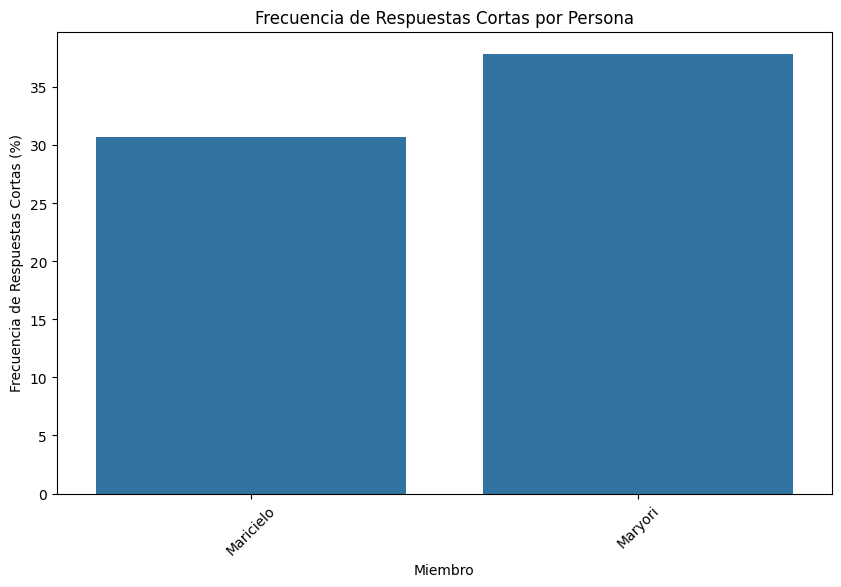

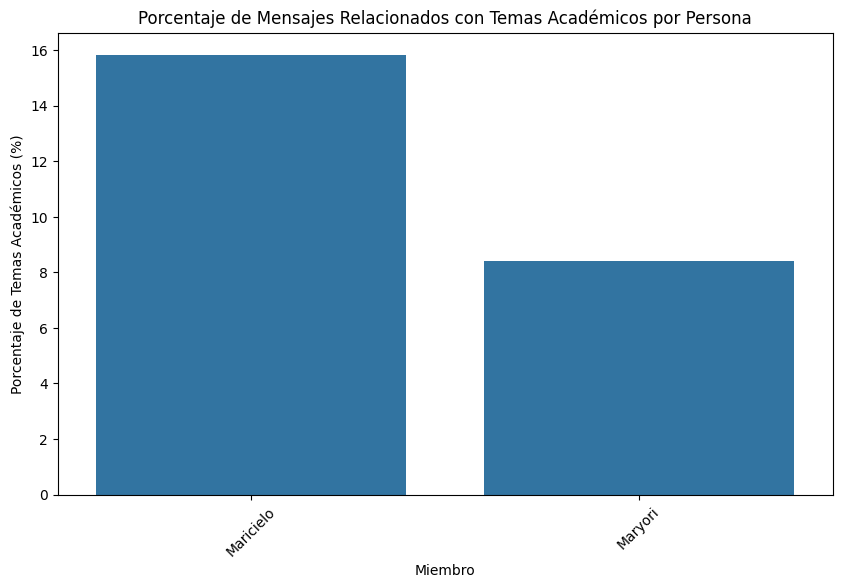

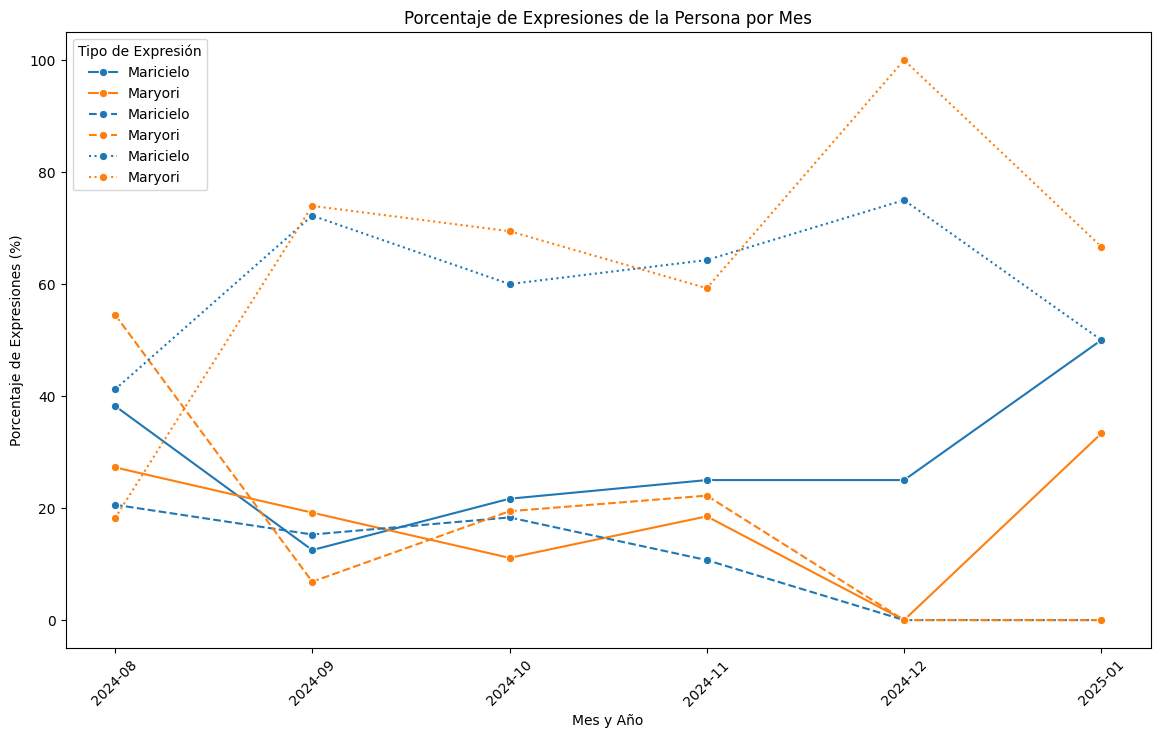

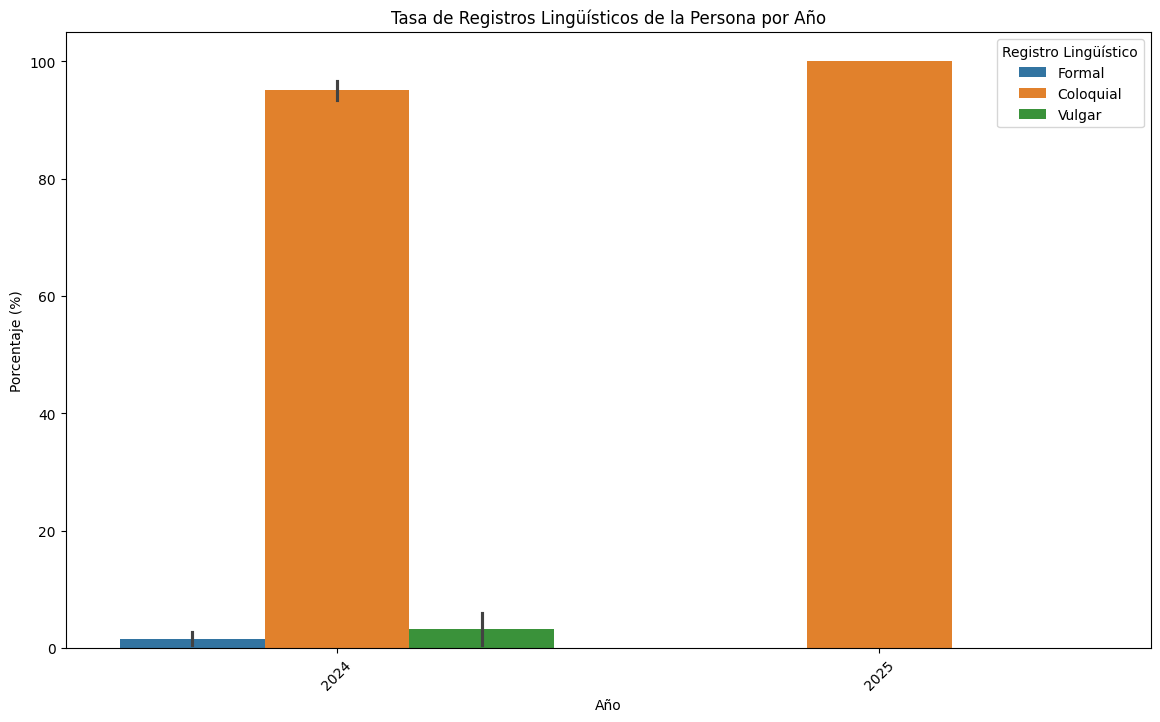

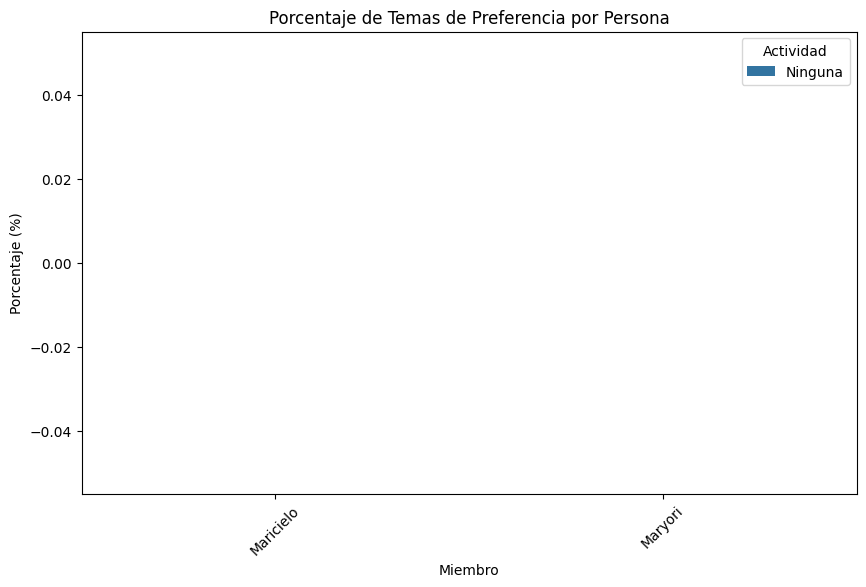

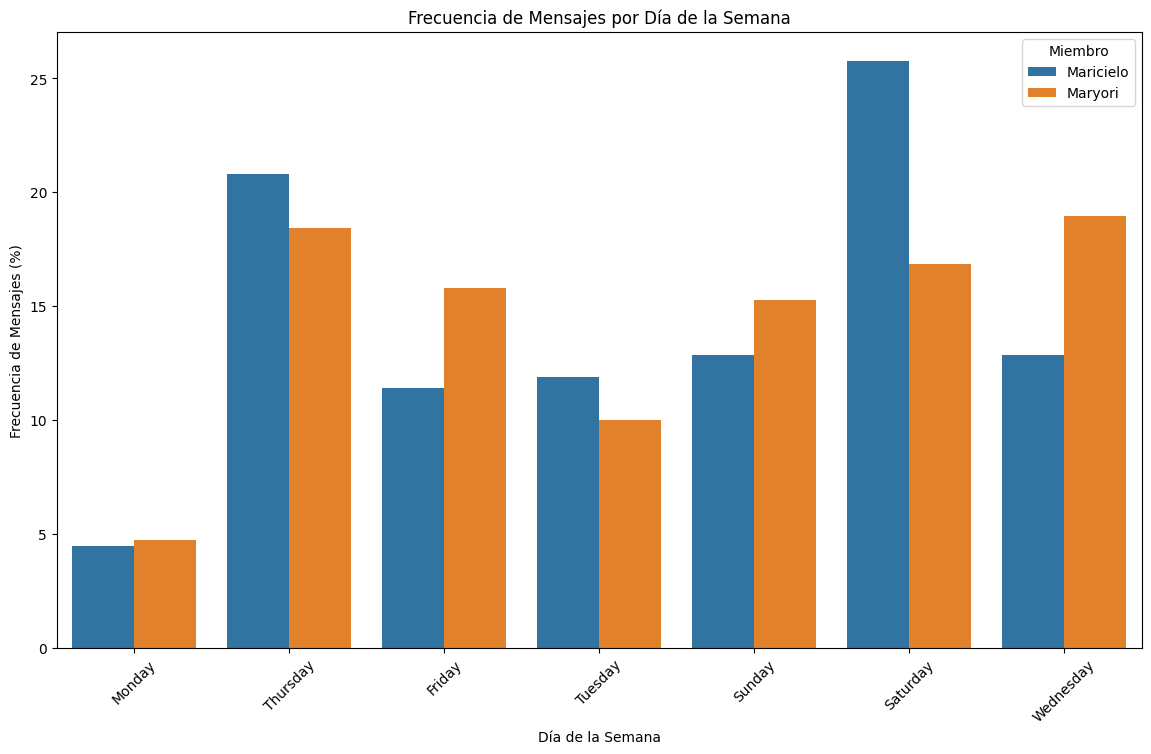

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Indicador 1: Frecuencia de Respuestas Cortas por Persona
df_frecuencia_pd = df_frecuencia.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=df_frecuencia_pd, x='Miembro', y='Frecuencia_Respuestas_Cortas')
plt.title('Frecuencia de Respuestas Cortas por Persona')
plt.xlabel('Miembro')
plt.ylabel('Frecuencia de Respuestas Cortas (%)')
plt.xticks(rotation=45)
plt.show()

# Indicador 3: Porcentaje de Mensajes Relacionados con Temas Académicos por Persona
df_porcentaje_temas_pd = df_porcentaje_temas.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=df_porcentaje_temas_pd, x='Miembro', y='Porcentaje_Temas_Academicos')
plt.title('Porcentaje de Mensajes Relacionados con Temas Académicos por Persona')
plt.xlabel('Miembro')
plt.ylabel('Porcentaje de Temas Académicos (%)')
plt.xticks(rotation=45)
plt.show()

# Indicador 2: Porcentaje de Expresiones de la Persona por Mes
df_porcentaje_emociones_pd = df_porcentaje_emociones.toPandas()
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_porcentaje_emociones_pd, x='Mes_Año', y='Porcentaje_Positivo', hue='Miembro', marker='o')
sns.lineplot(data=df_porcentaje_emociones_pd, x='Mes_Año', y='Porcentaje_Negativo', hue='Miembro', marker='o', linestyle='--')
sns.lineplot(data=df_porcentaje_emociones_pd, x='Mes_Año', y='Porcentaje_Neutral', hue='Miembro', marker='o', linestyle=':')
plt.title('Porcentaje de Expresiones de la Persona por Mes')
plt.xlabel('Mes y Año')
plt.ylabel('Porcentaje de Expresiones (%)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Expresión')
plt.show()

# Indicador 4: Tasa de Registros Lingüísticos de la Persona por Año
df_final_pd = df_final.toPandas()
plt.figure(figsize=(14, 8))
sns.barplot(data=df_final_pd, x='Año', y='Porcentaje', hue='Registro_Linguistico')
plt.title('Tasa de Registros Lingüísticos de la Persona por Año')
plt.xlabel('Año')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45)
plt.legend(title='Registro Lingüístico')
plt.show()

# Indicador 5: Porcentaje de Temas de Preferencia por Persona
df_actividad_pd = df_actividad.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=df_actividad_pd, x='Miembro', y='Porcentaje', hue='Actividad')
plt.title('Porcentaje de Temas de Preferencia por Persona')
plt.xlabel('Miembro')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45)
plt.legend(title='Actividad')
plt.show()

# Indicador 6: Frecuencia de Mensajes por Día de la Semana
df_frecuencia_mensajes_pd = df_frecuencia_mensajes.toPandas()
plt.figure(figsize=(14, 8))
sns.barplot(data=df_frecuencia_mensajes_pd, x='Dia_Semana', y='Frecuencia_Mensajes', hue='Miembro')
plt.title('Frecuencia de Mensajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Frecuencia de Mensajes (%)')
plt.xticks(rotation=45)
plt.legend(title='Miembro')
plt.show()

In [ ]:

#ESTADISTICA DESCRIPTIVA


In [25]:

#CORRELACION ENTRE DATOS
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation

# Preparar datos para correlación
df = df.withColumn("Cantidad_Palabras", col("Cantidad_Palabras").cast("integer"))
df = df.withColumn("Respuesta_Corta", col("Respuesta_Corta").cast("integer"))
df = df.withColumn("Temas_academicos", col("Temas_academicos").cast("integer"))
#df = df.withColumn("Cantidad_Actividad", col("Cantidad_Actividad").cast("integer"))

vector_cols = ["Cantidad_Palabras", "Respuesta_Corta","Temas_academicos"]
assembler = VectorAssembler(inputCols=vector_cols, outputCol="features")
df_vector = assembler.transform(df)


# Calcular matriz de correlación
matrix = Correlation.corr(df_vector, "features").head()[0]
correlation_matrix = matrix.toArray().tolist()

for row in correlation_matrix:
    print(row)

25/02/17 23:00:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


[1.0, -0.4368947241991987, 0.3546513962802244]
[-0.4368947241991987, 1.0, -0.25279870593562925]
[0.3546513962802244, -0.25279870593562925, 1.0]


In [ ]:
rdd2 = spark.sparkContext.textFile("CGRUPAL1.txt")

In [ ]:
messages = process_chat(rdd2)

estructura2 = StructType([
    StructField("Fecha", StringType(), True),
    StructField("Hora", StringType(), True),
    StructField("Miembro", StringType(), True),
    StructField("Mensaje", StringType(), True)
])

df2 = spark.createDataFrame(messages, schema=estructura2)

# Mostrar resultado
df2.show(10)

In [ ]:
from pyspark.sql.functions import size, split, when, length
# Agregar columnas de análisis de mensajes
df2 = df2.withColumn(
    "Cantidad_Palabras", 
    size(split("Mensaje", " "))
).withColumn(
    "Respuesta_Corta",
    when(
        (length("Mensaje") <= 20) & 
        (size(split("Mensaje", " ")) <= 3), 
        1
    ).otherwise(0)
)
df2.show(10)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

#Función para detectar sentimiento 
def analizar_sentimiento(texto):
    palabras_negativas = ['mal', 'terrible', 'horrible', 'peor', 'no', 'nunca', 'problema']
    palabras_positivas = ['bien', 'excelente', 'genial', 'bueno', 'gracias', 'si', 'claro']
    
    texto = texto.lower()
    if any(palabra in texto for palabra in palabras_negativas):
        return 'Negativo'
    elif any(palabra in texto for palabra in palabras_positivas):
        return 'Positivo'
    return 'Neutral'
    
#Registrar UDFs
sentimiento_udf = udf(analizar_sentimiento, StringType())
expresiones_negativas_udf = udf(lambda texto: 1 if analizar_sentimiento(texto) == 'Negativo' else 0, IntegerType())

#Crear DataFrame con expresiones negativas
df2 = df2.withColumn("Sentimiento", sentimiento_udf("Mensaje")) \
                         .withColumn("Expresiones_negativas", expresiones_negativas_udf("Mensaje"))
                         
expresiones_positivas_udf = udf(lambda texto: 1 if analizar_sentimiento(texto) == 'Positivo' else 0, IntegerType())

#Crear DataFrame con expresiones positivas
df2 = df2.withColumn("Sentimiento", sentimiento_udf("Mensaje")) \
                         .withColumn("Expresiones_positivas", expresiones_positivas_udf("Mensaje"))
                         
df2.show(10)

In [ ]:
def detectar_tema_academico(texto):
    palabras_academicas = ['tarea', 'examen', 'clase', 'profesor', 'curso', 'estudiar', 
                          'práctica', 'parcial', 'final', 'investigación', 'informe']
    texto = texto.lower()
    return 1 if any(palabra in texto for palabra in palabras_academicas) else 0

temas_academicos_udf = udf(detectar_tema_academico, IntegerType())

# Crear DataFrame con temas académicos
df2 = df2.withColumn("Temas_academicos", temas_academicos_udf("Mensaje"))
df2.show(10)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
print("Total de filas en df:", df.count())
print("Total de filas en df2:", df2.count())

df_union = df.union(df2)

print("Cantidad de filas después de unir:")
print("df_union:", df_union.count())




In [ ]:
df_union.limit(456).tail(1)  # Muestra solo la primera fila
